<h1>Synthetizing the insurance Dataset</h1>
<p>
The method is based on copula. In this version, I work with the non-categorical features. No grouping is performed.
The content is as follows:
    
<ol>
    <li><a ="#section1">Imports and Reading Datasets</a>  
    <li><a ="#section2">Exploratory Analysis</a>
    <li><a ="#section3">Step 1: Compute correlation matrix on real data</a>
    <li><a ="#section4">   Step 2: Multivariate Gaussian generation</a>
    <li><a ="#section5">   Step 3 and 4: From Gaussian to uniform to target distribution</a>
    <li><a ="#section5b">   Assessing Quality</a>
    <li><a ="#section6">  Synthetic Data: Snapshot</a>
    <li><a ="#section7">  Gathering More Stats and Insights</a>
    <li><a ="#section8">First Attempt at Parametric Copulas</a>
</ol>


<h2>1. Imports and Reading Dataset</h2><a id='section1'></a>
<p>
The dataset on Kaggle, <a href="https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset">here</a>. 
In this notebook, I use the version on my GitHub repository,
    <a href="https://github.com/VincentGranville/Main/blob/main/insurance.csv">here</a>.
<p>
<b>Features: </b> age, sex, bmi, children, smoker, region, charges. 
<p>
The last one is the response. Categorical fields (sex, smoker, regions) to be treated separately. Check out for 
outliers, 
missing values, 
values with commas inside,
and so on. Also, do we need to transform the data?
<p>
<b>Exercise 1</b><br>
Use dummy variables for categorical fields, and include them in the synthetization.

In [1]:
# copula_insurance_nogroup.py

import pandas as pd
from scipy.stats import norm
import numpy as np

filename = 'insurance.csv' 
data = pd.read_csv(filename)
print(data.head(10))

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692


Now using numerical fields only: age, bmi, children, charges

In [2]:
age = data.loc[:,"age"]
bmi = data.loc[:,"bmi"]
children = data.loc[:,"children"]
charges = data.loc[:,"charges"]

<a id='section2'></a>
<h2>2. Exploratory Analysis</h2>
<p>
The focus is to check out what kind of distributions we are dealing with, by plotting the distribution of each feature, and scatterplots for pair of features. In particular:
<ul>
<li> 'age' looks uniform except for the extremes (mixture of uniform and singular?)
<li> 'bmi' looks Gaussian
<li> 'children' looks like a geometric distribution
<li> 'charges' is bimodal
</ul>

(array([0.04728017, 0.02047183, 0.02047183, 0.0199844 , 0.01925327,
        0.01852213, 0.01827842, 0.01974069, 0.02022811, 0.02120296,
        0.02095925, 0.02071554, 0.01900955, 0.01779099, 0.02217781]),
 array([18.        , 21.06666667, 24.13333333, 27.2       , 30.26666667,
        33.33333333, 36.4       , 39.46666667, 42.53333333, 45.6       ,
        48.66666667, 51.73333333, 54.8       , 57.86666667, 60.93333333,
        64.        ]),
 <BarContainer object of 15 artists>)

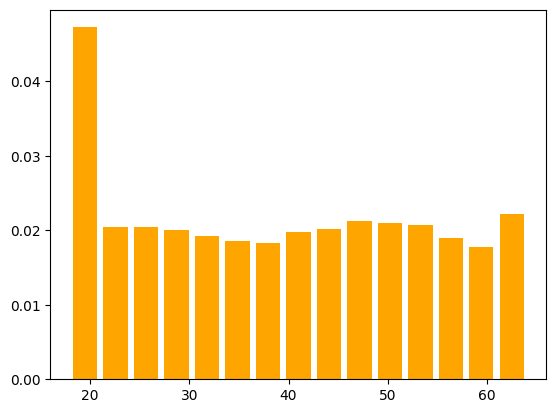

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
axes = plt.axes()
n_bins = 15  # n_bins = 20 produces periodic spikes, why?
plt.hist(age, n_bins, density = True, rwidth = 0.8, color = 'orange')

(array([0.51479821, 0.29058296, 0.21524664, 0.14080717, 0.02242152,
        0.0161435 ]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <BarContainer object of 6 artists>)

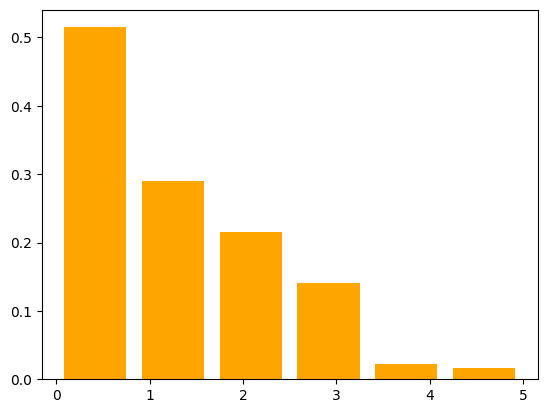

In [4]:
n_bins = 6
plt.hist(children, n_bins, density = True, rwidth = 0.8, color = 'orange') 

(array([0.00603216, 0.01327074, 0.02804953, 0.0464476 , 0.05760709,
        0.06273442, 0.0579087 , 0.04825725, 0.03951062, 0.02231898,
        0.0117627 , 0.00452412, 0.0039209 , 0.00060322, 0.00060322]),
 array([15.96 , 18.438, 20.916, 23.394, 25.872, 28.35 , 30.828, 33.306,
        35.784, 38.262, 40.74 , 43.218, 45.696, 48.174, 50.652, 53.13 ]),
 <BarContainer object of 15 artists>)

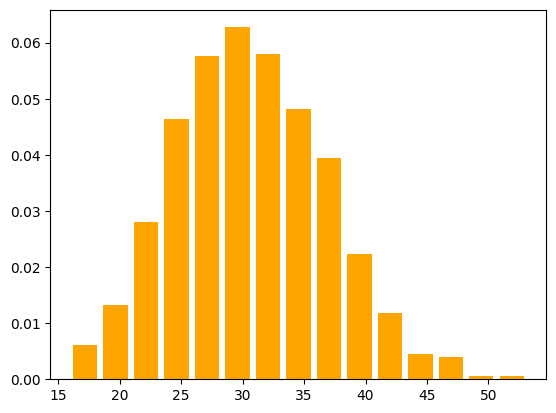

In [5]:
n_bins = 15
plt.hist(bmi, n_bins, density = True, rwidth = 0.8, color = 'orange') 

(array([382., 294., 258.,  87.,  78.,  50.,  32.,  18.,  44.,  41.,  30.,
         18.,   2.,   1.,   3.]),
 array([ 1121.8739  ,  5298.444174,  9475.014448, 13651.584722,
        17828.154996, 22004.72527 , 26181.295544, 30357.865818,
        34534.436092, 38711.006366, 42887.57664 , 47064.146914,
        51240.717188, 55417.287462, 59593.857736, 63770.42801 ]),
 <BarContainer object of 15 artists>)

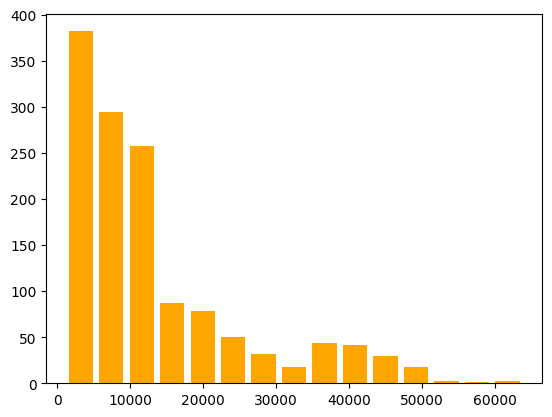

In [6]:
n_bins = 15 # a lot smoother with 10 bins
plt.hist(charges, n_bins, density = False, rwidth = 0.8, color = 'orange') 

<a id='section3'></a>
<h2>3. Step 1: Compute correlation matrix on real data</h2>

In [7]:
# need correlation matrix computed on real data, for Gaussian copula
r_data = np.stack((age, bmi, children, charges), axis = 0)
r_corr = np.corrcoef(r_data) 
print(r_corr)

[[1.         0.10927188 0.042469   0.29900819]
 [0.10927188 1.         0.0127589  0.19834097]
 [0.042469   0.0127589  1.         0.06799823]
 [0.29900819 0.19834097 0.06799823 1.        ]]


Also computing the means for each feature. Not needed here, but useful to see if they make sense and get an idea.

In [8]:
r_mu  = [np.mean(age), np.mean(bmi), np.mean(children), np.mean(charges)]
nobs_synth = len(age)
print("Mean: %5.2f %5.2f %5.2f %6.0f" % (r_mu[0],r_mu[1],r_mu[2],r_mu[3]))
print("Nobs: %4d" %(nobs_synth))
zero = [0, 0, 0, 0] 

Mean: 39.21 30.66  1.09  13270
Nobs: 1338


<a id='section4'></a>
<h2>4. Step 2: Multivariate Gaussian generation</h2>
<p>
Generate multivariate Gaussian with zero mean and covariance equal to correlation matrix on real data. We generate <code>nobs_synth</code> observations. In this case, the same number as in the real data. The use of a Gaussian copula here is similar to using Gaussians for the latent data in GAN. There are alternatives, such as Frank copula, in the same way that you could use (say) uniform deviates for latent features in GAN. If some features in the real data have very thick tail, a Gaussian copula, though theoretically correct (especially if the dataset is large) may undersample extremes.
<p>
First, we want to control all sources of randomness for replicability and to study volatility. This is done with <code>seed</code>. When saving results, don't forget to save the seed that you used as well.

In [9]:
seed = 453
np.random.seed(seed)

In [10]:
# this step to reconstruct correl structure in synth. data
gfg = np.random.multivariate_normal(zero, r_corr, nobs_synth) 
g_age = gfg[:,0]
g_bmi = gfg[:,1]
g_children = gfg[:,2]
g_charges = gfg[:,3]

<a id='section5'></a>
<h2>5. Step 3 and 4: From Gaussian to uniform to target distribution</h2>
<p>
From the correlated Gaussian with the target correlation structure, extract marginals (the features) and turn them into uniforms on [0, 1]. Then transform the uniforms into the correct target distribution: the empirical distribution of the real data, for each feature. The correlation structure is preserved.

In [11]:
s_data = []

for k in range(nobs_synth):  

    # Step 3: first get uniform distrib. for each feature
    u_age = norm.cdf(g_age[k])
    u_bmi = norm.cdf(g_bmi[k])
    u_children = norm.cdf(g_children[k])
    u_charges = norm.cdf(g_charges[k])

    # Step 4: turn uniform into target distrib.
    s_age = np.quantile(age, u_age)                # synthesized age 
    s_bmi = np.quantile(bmi, u_bmi)                # synthesized bmi
    s_children = np.quantile(children, u_children) # synthesized children
    s_charges = np.quantile(charges, u_charges)    # synthesized charges
    s_data.append((s_age,s_bmi,s_children, s_charges))

s_data = np.array(s_data)

<a id='sectionx'></a>
<h2>6. Assessing Quality</h2>

In [12]:
s_mu = np.mean(s_data, axis=0)
print("Mean Synth: %5.2f %5.2f %5.2f %6.0f" % (s_mu[0],s_mu[1],s_mu[2],s_mu[3]))
print("Mean Real : %5.2f %5.2f %5.2f %6.0f" % (r_mu[0],r_mu[1],r_mu[2],r_mu[3]))

Mean Synth: 38.84 30.65  1.02  13328
Mean Real : 39.21 30.66  1.09  13270


In [13]:
s_corr = np.corrcoef(np.transpose(s_data))
print("Correlation, real data\n")
print(r_corr)
print("\nCorrelation, synthetic data\n")
print(s_corr)

Correlation, real data

[[1.         0.10927188 0.042469   0.29900819]
 [0.10927188 1.         0.0127589  0.19834097]
 [0.042469   0.0127589  1.         0.06799823]
 [0.29900819 0.19834097 0.06799823 1.        ]]

Correlation, synthetic data

[[1.         0.09547703 0.02413221 0.28762577]
 [0.09547703 1.         0.05036735 0.15233377]
 [0.02413221 0.05036735 1.         0.05744995]
 [0.28762577 0.15233377 0.05744995 1.        ]]


<b>Exercise 2</b><br>
Check if pairwise feature scatter plots on real and synth. data are similar.
<p>
<b>Exercise 3</b><br>    
Try with different seeds. Assess volatility of the results. Compute confidence intervals for mean age and so on.

<a id='section6'></a>
<h2>7. Synthetic Data: Snapshot</h2>

In [14]:
# --- np to pandas array
s_data = pd.DataFrame(s_data, columns = ['age','bmi','children','charges'])
print(s_data.head(10))

    age        bmi  children       charges
0  26.0  35.200000       3.0   7203.616777
1  34.0  29.193193       2.0   9526.725877
2  32.0  24.761289       1.0   9381.264084
3  19.0  26.885000       2.0   3333.067695
4  23.0  25.665819       0.0   9793.251928
5  27.0  28.837104       3.0  21223.696804
6  24.0  28.000000       0.0   2903.971962
7  33.0  25.534879       0.0   6626.613634
8  51.0  30.347082       1.0  12920.077903
9  18.0  21.755000       1.0   4932.769237


In [15]:
r_data = np.transpose(r_data)
r_data = pd.DataFrame(r_data, columns = ['age','bmi','children','charges'])
print(r_data.head(10))

    age     bmi  children      charges
0  19.0  27.900       0.0  16884.92400
1  18.0  33.770       1.0   1725.55230
2  28.0  33.000       3.0   4449.46200
3  33.0  22.705       0.0  21984.47061
4  32.0  28.880       0.0   3866.85520
5  31.0  25.740       0.0   3756.62160
6  46.0  33.440       1.0   8240.58960
7  37.0  27.740       3.0   7281.50560
8  37.0  29.830       2.0   6406.41070
9  60.0  25.840       0.0  28923.13692


<a id='section7'></a>
<h2>8. Gathering More Stats and Insights</h2>
<p>
The goal is to better compare synthetic with real data, and save summary stats for future comparison with other seeds (to assess volatility) and other methods: GAN, copula with grouping (to reduce algorithmic bias), Frank copula, copula with empirical quantiles replaced by parametric distributions fit to the real data, and feature substitution to reduce algorithmic bias.

In [16]:
r_min = np.min(r_data,axis=1)
s_min = np.min(s_data,axis=0)
r_max = np.max(r_data,axis=1)
s_max = np.max(s_data,axis=0)
r_std = np.std(r_data,axis=1)
s_std = np.std(s_data,axis=0)

print("Min Real:\nage\t\t%9.3f\nbmi\t\t%9.3f\nchildren\t%9.3f\ncharges\t\t%9.3f\n" 
      % (r_min[0],r_min[1],r_min[2],r_min[3]))
print("Min Synth:\nage\t\t%9.3f\nbmi\t\t%9.3f\nchildren\t%9.3f\ncharges\t\t%9.3f\n" 
      % (s_min[0],s_min[1],s_min[2],s_min[3]))
print("Max Real:\nage\t\t%9.3f\nbmi\t\t%9.3f\nchildren\t%9.3f\ncharges\t\t%9.3f\n" 
      % (r_max[0],r_max[1],r_max[2],r_max[3]))
print("Max Synth:\nage\t\t%9.3f\nbmi\t\t%9.3f\nchildren\t%9.3f\ncharges\t\t%9.3f\n" 
      % (s_max[0],s_max[1],s_max[2],s_max[3]))
print("Std Real:\nage\t\t%9.3f\nbmi\t\t%9.3f\nchildren\t%9.3f\ncharges\t\t%9.3f\n" 
      % (r_std[0],r_std[1],r_std[2],r_std[3]))
print("Std Synth:\nage\t\t%9.3f\nbmi\t\t%9.3f\nchildren\t%9.3f\ncharges\t\t%9.3f" 
      % (s_std[0],s_std[1],s_std[2],s_std[3]))

Min Real:
age		    0.000
bmi		    1.000
children	    3.000
charges		    0.000

Min Synth:
age		   18.000
bmi		   15.997
children	    0.000
charges		 1133.380

Max Real:
age		16884.924
bmi		 1725.552
children	 4449.462
charges		21984.471

Max Synth:
age		   64.000
bmi		   53.095
children	    5.000
charges		62555.918

Std Real:
age		 7304.624
bmi		  739.660
children	 1917.470
charges		 9511.522

Std Synth:
age		   13.975
bmi		    6.115
children	    1.189
charges		12047.968


<b>Exercise 4</b><br>
Add 25- and 75-percentiles, both for real and synthetic.
<p>
<b>Exercise 5</b><br> 
Compute distance between statistical summaries on real and synthetized data. To do so, transform real data so that each feature has zero mean and unit variance. Make the comparison between standardized data and the synth data produced on the standardized version of the real data. Then try different seeds, and see which ones provide best fit.
<p>
<b>Exercise 6</b><br>
In addition to the above statistics in Exercise 5, also include the correlation matrices. No need to transform the data here: these matrices are invariant under linear transformations. To be discussed in the GAN module. 
<p>
<b>Exercise 7</b><br>
Instead of summary stats, use Hellinger distance for comparison purposes: (1) feature-wise, (2) max or average Hellinger across features.

<b>Conclusions</b><p>
The copulas do a great job at replicating the correlation structure and marginal distributions. They work with both ordinal and continuous features, producing ordinal values for ordinal features. Replication of the results is easy thanks to
<code>seed</code>. Also, it is a very fast technique. We will see that copulas, unlike GANs, are not great at replicating non linear structures (correlation is a linear structure). Also, unless using parametric distributions for the quantiles, you can't sample outside the range of observations (min, max) in the real data. This issue is true for all features, but easy to fix.

<a id='section8'></a>
<h2>9. First Attempt at Parametric Copulas</h2>
<p>
Let's replace the empirical quantiles for 'children' by quantiles of a geometric distribution of parameter <em>p</em>. 
The parameter is estimated on the real data, as the inverse of the mean for the feature in question. The
feature <code>s_children</code> obtained in the synthetic data will have a
sister feature <code>s_param_children</code>. See what happens when we switch them. Are the results worse? Are we able to sample outside the range? (that was the purpose). Likewise, we could use a GMM (Gaussian mixture model) for the bimodal 'charges', preferably after a log-transform to make sure we do not generate negative charges in the synthetic data (and typically, expenses may follow a log-normal rather than normal distribution).

In [132]:
q = np.mean(children)
children_geom_param = 1- q/(q+1) # numpy geometric distrib. starts at 1, ours start at 0
children_geom = np.random.geometric(children_geom_param, len(children))
children_geom = children_geom - np.ones(len(children)) # we start at 0, not at 1

s_data_v2 = []

for k in range(nobs_synth):  

    # Step 3: first get uniform distrib. for each feature
    u_age = norm.cdf(g_age[k])
    u_bmi = norm.cdf(g_bmi[k])
    u_children = norm.cdf(g_children[k])
    u_charges = norm.cdf(g_charges[k])

    # Step 4: turn uniform into target distrib.
    s_age = np.quantile(age, u_age)                # synthesized age 
    s_bmi = np.quantile(bmi, u_bmi)                # synthesized bmi
    s_children = np.quantile(children, u_children) # synthesized children
    s_children_geom = np.quantile(children_geom, u_children) # synthesized children_geom
    s_charges = np.quantile(charges, u_charges)    # synthesized charges
    s_data_v2.append((s_age,s_bmi,s_children, s_charges,s_children_geom))

s_data_v2 = np.array(s_data_v2)

Now checking some summary stats. Check out for maximum number of children in children_geom. In some instances it was too high, meaning a geometric distribution is not a great fit. It does sample outside the range and reduces overfit if present, but a truncated geometric or a 2-param distribution is probably a better fit.

In [137]:
s_min_v2 = np.min(s_data_v2,axis=0)
s_max_v2 = np.max(s_data_v2,axis=0)
s_mean_v2 = np.mean(s_data_v2,axis=0)
s_std_v2 = np.std(s_data_v2,axis=0)
s_corr_v2 = np.corrcoef(np.transpose(s_data_v2))

r_min = np.min(r_data,axis=0)
r_max = np.max(r_data,axis=0)
r_mean = np.mean(r_data,axis=0)
r_std = np.std(r_data,axis=0)
r_corr = np.corrcoef(np.transpose(r_data))

print("\ts_children | s_children_param | s_real\n")
print("min\t%2d\t%2d\t%2d" %(s_min_v2[2],s_min_v2[4],r_min[2]))
print("max\t%2d\t%2d\t%2d" %(s_max_v2[2],s_max_v2[4],r_max[2]))
print("mean\t%5.3f\t%5.3f\t%5.3f" %(s_mean_v2[2],s_mean_v2[4],r_mean[2]))
print("std\t%5.3f\t%5.3f\t%5.3f" %(s_std_v2[2],s_std_v2[4],r_std[2]))
print("\ncorrel real:\n",r_corr)
print("\ncorrel synth v2\n",s_corr_v2)

	s_children | s_children_param | s_real

min	 0	 0	 0
max	 5	10	 5
mean	1.020	1.006	1.095
std	1.189	1.460	1.205

correl real:
 [[1.         0.10927188 0.042469   0.29900819]
 [0.10927188 1.         0.0127589  0.19834097]
 [0.042469   0.0127589  1.         0.06799823]
 [0.29900819 0.19834097 0.06799823 1.        ]]

correl synth v2
 [[1.         0.09547703 0.02413221 0.28762577 0.02636274]
 [0.09547703 1.         0.05036735 0.15233377 0.04441195]
 [0.02413221 0.05036735 1.         0.05744995 0.93000697]
 [0.28762577 0.15233377 0.05744995 1.         0.04825301]
 [0.02636274 0.04441195 0.93000697 0.04825301 1.        ]]


Now showing frequency and cumulative distribution for (n1, n3) where n1 is number of children in 
s_children_param and n3 is
number of children in r_children, ordered by frequency. 

In [155]:
r_data_t = np.transpose(r_data)
count = {}
for k in range(nobs_synth):
    n_children1 = int(s_data_v2[k,4]+0.5) # parametric model (geom. distrib.)
    n_children2 = int(s_data_v2[k,2]+0.5) # parameter-free
    n_children3 = int(r_data_t[k][2])     # real data
    key = (n_children1,n_children3)
    if key in count:
        count[key] += 1
    else:
        count[key]=1
        
cnt = 0
x = []
y = []
size = []
for w in sorted(count, key = count.get, reverse = True):
    cnt += count[w]
    skey = str(w)
    freq = count[w]/nobs_synth
    cfreq = cnt/nobs_synth
    x.append(w[0])
    y.append(w[1])
    size.append(count[w])
    print("%10s\t%4.3f\t%4.3f" % (skey, freq, cfreq))

    (0, 0)	0.223	0.223
    (0, 1)	0.132	0.354
    (1, 0)	0.099	0.453
    (0, 2)	0.087	0.540
    (0, 3)	0.061	0.601
    (1, 1)	0.052	0.653
    (2, 0)	0.045	0.698
    (1, 2)	0.043	0.741
    (3, 0)	0.034	0.775
    (1, 3)	0.028	0.803
    (2, 1)	0.027	0.830
    (2, 2)	0.025	0.855
    (2, 3)	0.018	0.873
    (4, 0)	0.016	0.889
    (3, 1)	0.013	0.902
    (0, 4)	0.009	0.911
    (4, 1)	0.009	0.920
    (4, 2)	0.009	0.929
    (0, 5)	0.007	0.936
    (5, 1)	0.007	0.943
    (5, 0)	0.006	0.949
    (3, 2)	0.006	0.955
    (1, 4)	0.005	0.960
    (6, 0)	0.004	0.965
    (5, 2)	0.004	0.969
    (2, 4)	0.004	0.972
    (3, 3)	0.004	0.976
    (4, 3)	0.003	0.979
    (6, 2)	0.003	0.982
    (5, 3)	0.002	0.984
    (1, 5)	0.002	0.987
    (7, 2)	0.002	0.989
    (9, 1)	0.001	0.990
    (7, 1)	0.001	0.992
    (3, 5)	0.001	0.993
    (9, 0)	0.001	0.995
    (2, 5)	0.001	0.996
    (4, 4)	0.001	0.997
    (7, 3)	0.001	0.998
   (10, 0)	0.001	0.999
    (6, 3)	0.001	0.999
    (4, 5)	0.001	1.000
